# A Tale on GLM (Generalized Linear Model) - Optimization Method

So the story begins when I am trying to compare GLM output from R and Python and I found out that the result are similar but not exactly the same. The answer is obvious, it is due to their optimization algorithm even when the two of them use Iterated Reweighted Least Square (IRLS). This bug me quite a bit since when I try to use other optimization technique, e.g. Nelder-Mead (NM), Broyden-Fletcher-Goldfarb-Shanno (BFGS),the result differ quite significant.  

On the other hand, I also have been tweaking a little bit on deep learning using PyTorch libraries and I have no confidence on the code I wrote since there is no numerical result to compare. So, here we are.

This notebook won't discuss anything on the optimization method and why it works and also won't discuss the basic of GLM since I believe there are a lot of resources which is very clear to explain (my recommendation is [AItools4Actuaries](https://aitools4actuaries.com/Ch3/Ch3A%20GLM.html)).  

This notebook is a personal note to memorize how to estimate the predictor in GLM (since one of my client asked me and I am not satisfy with my answer) and to familiarize on PyTorch framework.

# Packages

In [1]:
# General Data Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GLM Model
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.metrics import mean_poisson_deviance
from scipy.stats import poisson 

# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F

# Generate Data

For simplicity, we assume we have 3 predictor (`variable_1`, `variable_2` and `variable_3`) and we are going to assume the `claim_count` is Poisson ($\lambda$) distributed with $\lambda$ as follow 
$$
\lambda = 1.2 + 0.4 \mathbb{I}_{x_1 = a} - 0.3\mathbb{I}_{x_1 = b} + 0.8 \mathbb{I}_{x_1 = c}  - 0.2 x_2 + 1.2 \cos{(x_3)} + \log(\text{offset})
$$
where $\mathbb{I}_{x_1 = a}$ is an indicator function if `variable_1` is `a`

In [2]:
np.random.seed(108)
n_obs = 100_000

model_df = pd.DataFrame({
    'variable_1' : np.random.choice(a=['a', 'b', 'c'], size=n_obs),
    'variable_2' : np.random.uniform(low=0, high=20, size=n_obs),
    'variable_3' : np.random.normal(loc = 0, scale = 1, size = n_obs),
    'exposure' : np.round(np.random.uniform(low=0.2, high=1, size=n_obs),4),
    })
model_df['lambda'] = (
    1.2 + 
    model_df['variable_1'].map({'a': 0.4, 'b': -0.3, 'c': 0.8}) - 
    0.2*model_df['variable_2'] + 
    1.2*np.cos(model_df['variable_3']) + 
    np.log(model_df['exposure'])
).clip(0)
model_df['claim_count'] = np.random.poisson(lam = model_df['lambda'])
model_df

,variable_1,variable_2,variable_3,exposure,lambda,claim_count
0,b,7.563060,-0.302359,0.3453,0.000000,0
1,c,5.419909,-0.041613,0.7115,1.774599,0
2,c,4.864539,-0.013409,0.9464,2.171894,1
3,c,12.394991,-1.153324,0.3808,0.000000,0
4,a,1.471028,-0.435920,0.7594,2.118346,0
...,...,...,...,...,...,...
99995,c,14.483830,-1.442644,0.6825,0.000000,0
99996,c,17.158324,-1.057541,0.3563,0.000000,0
99997,b,10.751592,-0.409207,0.2165,0.000000,0
99998,a,15.931183,-0.500684,0.7192,0.000000,0


In [3]:
print(f'The Negative Log Likelihood of the data is {-1 * np.sum(poisson.logpmf(model_df['claim_count'],  mu = model_df['lambda'])):.4f}')

The Negative Log Likelihood of the data is 47933.3287


## Data Quick Check

In [4]:
model_df.groupby('variable_1').describe()

variable_2                                                      \
                count       mean       std       min       25%        50%   
variable_1                                                                  
a             33282.0   9.947663  5.790902  0.001318  4.931616   9.933061   
b             33472.0  10.033054  5.793543  0.000485  4.995186  10.091401   
c             33246.0  10.033080  5.783112  0.000395  5.054267  10.005373   

                                 variable_3            ...    lambda  \
                  75%        max      count      mean  ...       75%   
variable_1                                             ...             
a           14.939579  19.999223    33282.0 -0.001623  ...  0.783737   
b           15.058644  19.998942    33472.0 -0.014362  ...  0.088038   
c           15.052614  19.999914    33246.0 -0.000606  ...  1.168648   

                     claim_count                                                
                 max       count      mean       std  min  25%  50%  75%   max  
variable_1                                                                      
a           2.737580     33282.0  0.435731  0.930425  0.0  0.0  0.0  0.0   9.0  
b           2.043901     33472.0  0.186723  0.587049  0.0  0.0  0.0  0.0   8.0  
c           3.162738     33246.0  0.615773  1.113149  0.0  0.0  0.0  1.0  11.0  

[3 rows x 40 columns]

In [5]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_1   100000 non-null  object 
 1   variable_2   100000 non-null  float64
 2   variable_3   100000 non-null  float64
 3   exposure     100000 non-null  float64
 4   lambda       100000 non-null  float64
 5   claim_count  100000 non-null  int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 4.2+ MB


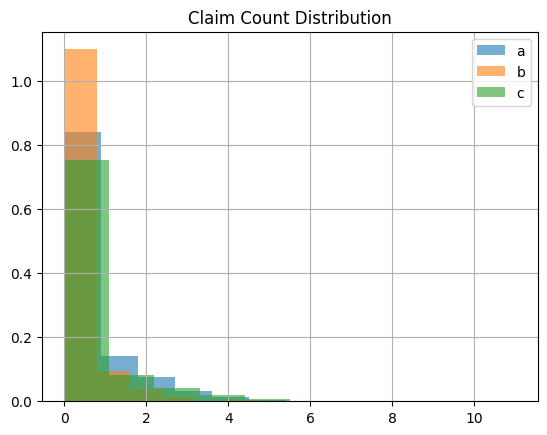

In [6]:
model_df.groupby('variable_1')['claim_count'].hist(legend=True, alpha=0.6, density = True)
plt.title('Claim Count Distribution')
plt.show()

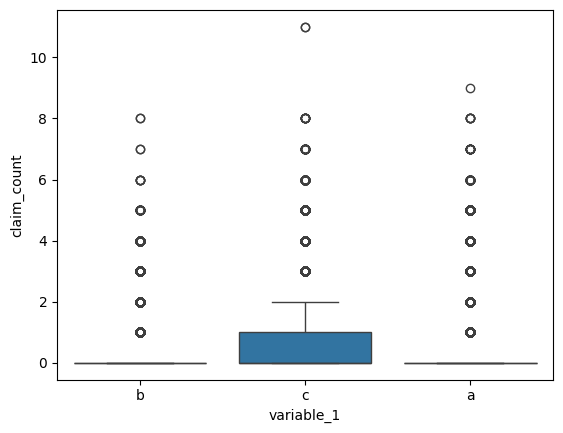

In [7]:
sns.boxplot(x = model_df['variable_1'], y = model_df['claim_count'])
plt.show()

# GLM Model

Here we only fit the model directly

In [8]:
glm_model = glm('claim_count ~ variable_1 + variable_2 + variable_3', 
                    offset = np.log(model_df['exposure']),
                    data = model_df,
                    family = sm.families.Poisson())
glm_result = glm_model.fit()
glm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            claim_count   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58425.
Date:                Sat, 17 Jan 2026   Deviance:                       62278.
Time:                        09:27:43   Pearson chi2:                 7.43e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4817
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.3416      0.010    137.513      0.000       1.322       1.361
variable_1[T.b]    -0.8430      0.015    -55.710      0.000      -0.873      -0.813
variable_1[T.c]     0.3622      0.011     33.368      0.000       0.341       0.383
variable_2         -0.2645      0.001   -187.903      0.000      -0.267      -0.262
variable_3          0.0001      0.005      0.028      0.978      -0.009       0.010
===================================================================================
"""

# Neural Network

Now we are going to make a GLM from PyTorch model that hopefully can replicate the result from GLM. The basic idea is to have 1 layer with identity activation function where the loss function would be the deviance of the model. Since we assume the distribution of the model is Poisson we are going to use the Negative Log Likelihood (NLL) (Why?).

## Data Preparation

We need to convert the data into tensor type and create the Neural Network model from scratch

In [9]:
NN_df = model_df.copy()
X_train = pd.get_dummies(NN_df, columns=['variable_1'], drop_first=True, dtype=int).drop(columns=['exposure', 'lambda', 'claim_count'])
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_train_name = X_train.columns
exposure = model_df['exposure']
claim_count = model_df['claim_count']

X_train, exposure, claim_count = torch.tensor(X_train.values, dtype = torch.float32), torch.tensor(exposure, dtype = torch.float32), torch.tensor(claim_count, dtype = torch.float32)

In [10]:
class GLM_from_NN(nn.Module):
    def __init__(self, seed, features_):
        super(GLM_from_NN, self).__init__()
        torch.manual_seed(seed)
        self.model_glm = nn.Linear(features_, 1)
    
    def forward(self, x, offset_):
        return torch.exp(self.model_glm(x).flatten())* offset_

In [11]:
glm_NN = GLM_from_NN(
    seed = 101, features_= X_train.shape[1]
    )

In [12]:
def train_GLM_NN(NN_model, train_data, exposure_data, target_data, optimizer_function, n_epochs):
    loss_function = nn.PoissonNLLLoss(log_input = False, reduction='sum')
    history = {"loss": []}  
    for epoch in range(n_epochs):
        NN_model.train()
        
        pred_train = NN_model(train_data, exposure_data)
        loss_ = loss_function(pred_train, target_data)
        history['loss'].append(loss_.item())
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
        
    NN_model.eval()
    return history
optimizer = torch.optim.NAdam(glm_NN.parameters(), lr = 0.01)


## Neural Network Result

In [13]:
history = train_GLM_NN(glm_NN, X_train, exposure, claim_count, optimizer, n_epochs= 2_000)

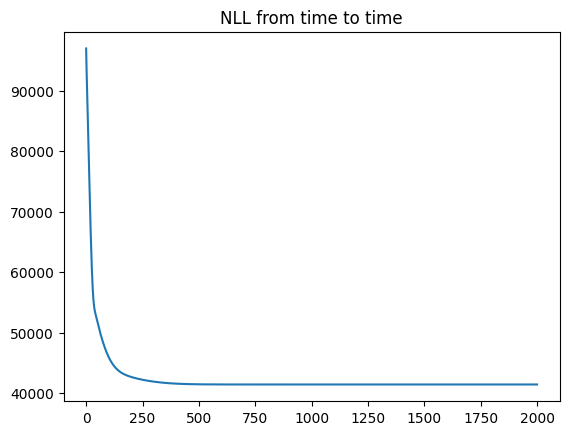

In [14]:
plt.plot(history['loss'])
plt.title('NLL from time to time')
plt.show()

# Moment of Truth

As we can see below, the parameter of `glm results` and `glm_NN` don't differ significantly up to 4 floating points.

## Parameter Value

In [15]:
print(f'List of the parameter from GLM')
for i in range(X_train_name.shape[0]+1):
    print(f'{glm_result.params.index[i]} {glm_result.params.iloc[i]:.6f}')

List of the parameter from GLM
Intercept 1.341557
variable_1[T.b] -0.842978
variable_1[T.c] 0.362178
variable_2 -0.264452
variable_3 0.000135


In [16]:
print(f'List of the parameter from PyTorch: \n intercept: {glm_NN.model_glm.bias.item():.6f}')
for i in range(X_train_name.shape[0]):
    print(f'{X_train_name[i]}: {glm_NN.model_glm.weight[0][i].item():.6f}')    

List of the parameter from PyTorch: 
 intercept: 1.341554
variable_1_b: -0.842975
variable_1_c: 0.362180
variable_2: -0.264452
variable_3: 0.000135


## Negative Loglikehood

This result rather confusing since the parameter is not significantly differ one to another but the negative loglikelihood differ significantly. It turns out that the NLL function doesn't include the exposure or offset in the calculation

In [17]:
print(f'The NLL from GLM is {-1*glm_result.llf:.4f} while from PyTorch for 1,000 iteration is {history['loss'][-1]:.4f} but for 6 iteration like the GLM is {history['loss'][5]:.4f}')

The NLL from GLM is 58424.7523 while from PyTorch for 1,000 iteration is 41427.3008 but for 6 iteration like the GLM is 89111.8594


In [18]:
loss_ = nn.PoissonNLLLoss(log_input = False, reduction='sum')
GLM_NLL = loss_(torch.tensor(glm_result.predict(model_df) * model_df['exposure']), claim_count)
PyTorch_pred = glm_NN(X_train, exposure)
PyTorch_NLL = loss_(PyTorch_pred, claim_count)

print(f'The NLL with PyTorch module from GLM is {GLM_NLL:.4f} while from PyTorch for 1,000 iteration is {PyTorch_NLL:.4f}')

The NLL with PyTorch module from GLM is 41427.3005 while from PyTorch for 1,000 iteration is 41427.3008


## Mean Poisson Deviance

As expected as well that the Mean Poisson Deviance also not significantly differ

In [19]:
PyTorch_NN_deviance = mean_poisson_deviance(
        claim_count.detach().numpy() / exposure.detach().numpy(), glm_NN(X_train, exposure).detach().numpy() / exposure.detach().numpy(), sample_weight = exposure.detach().numpy()
    )
GLM_deviance = mean_poisson_deviance(
     model_df["claim_count"]/model_df["exposure"], glm_result.predict(model_df), sample_weight=model_df["exposure"]
)

print(f'Mean Poisson Deviance from PyTorch is {PyTorch_NN_deviance:.6f} while Mean Poisson Deviance from GLM is {GLM_deviance:.6f}') 


Mean Poisson Deviance from PyTorch is 1.038954 while Mean Poisson Deviance from GLM is 1.038954


# Conclusion

It has been shown in this notebook that we can estimate GLM parameters using PyTorch libraries and it opens up a new optimization methods that are available in PyTorch library. The result of the parameters are almost similar up to 4 floating-points. 

At this point I feel more confident on creating a simple PyTorch module since I made a lot of error in the process.